# Table of Contents

#### 1 Necessary Python Imports and Setup
#### 2 Cleaning and Organizing the Data for Analysis
* Importing and Formatting
* Dropping Extra Columns
* Missing Values

#### 3 Initial Data Exploration
* Research Questions
* Initial Exploration of Date Contingency Table
* Some Toy Probability Questions


#### 4 Yearly Trends
* Yearly Trends
* Pearson Correlation Coefficient
* Hypothesis Testing for Linear Regression

#### 4 Exploration of Monthly Trends

---

# 1 Necessary Python Imports and Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

sns.set_palette("Dark2")

---
# 2 Cleaning and Organizing the Data for Analysis

Alright, so let's get our data in here and take a look at what we've got.

*The data comes from the Vancouver Open Data Catalogue. It was extracted on 2017-07-18 and it contains 530,652 records from 2003-01-01 to 2017-07-13.*

In [3]:
crime_df = pd.read_csv("vancouver_crime.csv")

crime_df.head()
print(crime_df.shape)

(530652, 12)


A sample of 530652 crimes in Vancouver!

*For the purposes of this project, I am going to pare down the data a little bit into something more workable. There is some great info in here, but also some extra details that I don't want to deal with while I work with the data.*

### Dropping Extra Columns
First things first, let's get rid of the X, Y, Latitude, and Longitude columns. I am satisfied with letting "Neighborhood" and "Hundred_Block" be representative of the location of the crime.

Next, there is a LOT of "time" information here.
Some of these catagories are great and useful seperately like the Year and Month of the crime.

I am less concerned about which day in the month a crime happened. I believe this is caught well enough by the month column, so I am just going to drop this "Day" column too.

Similarly, I'm less interested in where in the hour crime happened than when in the day a crime happened - I'm going to combine the Minute column into the Hour column. 



In [4]:
df = crime_df

df["HOUR"] = df.apply(
    lambda row:
        round(
            row["HOUR"] + (0.01 * row["MINUTE"] * (100/60)),
            2
        ),
    axis=1
)


df.drop(
    columns = ["X", "Y", "Latitude", "Longitude", "DAY", "MINUTE"],
    inplace = True,
)

df.head()

,TYPE,YEAR,MONTH,HOUR,HUNDRED_BLOCK,NEIGHBOURHOOD
0,Other Theft,2003,5,16.25,9XX TERMINAL AVE,Strathcona
1,Other Theft,2003,5,15.33,9XX TERMINAL AVE,Strathcona
2,Other Theft,2003,4,16.67,9XX TERMINAL AVE,Strathcona
3,Other Theft,2003,4,11.25,9XX TERMINAL AVE,Strathcona
4,Other Theft,2003,4,17.75,9XX TERMINAL AVE,Strathcona


This is looking pretty good, and very workable. 
For the sake of our later visualizations, the minutes have been converted into proportions of the full hours. The small sacrifice in readibility will be worth a smoother visualization, I think.

The last thing we are going to do is make a function to the Month's of the year back into their names, for readability. We will not use this just yet, because for now I'd still like to preserve the order of the months.

In [5]:
monthDict = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sep',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}

def translate_months(df):
    """
    Takes the dataframe and changes the integer month values to text month values, returning the new dataframe.
    """
    df["MONTH"] = df.apply(
        lambda row:
            monthDict[row["MONTH"]],
        axis = 1
    )
    return df

def translate_month_columns(df):
    """
    Takes the dataframe and changes the integer month columns to text month columns, returning the dataframe.
    """
    df = df.rename(columns = monthDict)
    return df
    

This leaves us with some extremely telling variables to work with!
We have the following types of data in our study:
1. **Type** - a nominal, catagorical variable describing the type of crime committed.
2. **Year** - a nominal, ordinal variable describing the year the crime was committed.
3. **Month** - a nominal, ordinal variable describing the month of the year the crime was committed.
4. **Hour** - a discrete, numerical variable describing the minute of the day that the crime was committed.
5. **Hundred Block** - a nominal, catagorical variable describing the rough block in Vancouver the crime was committed at.
6. **Neighborhood** - a nominal, catagorical variable describing the neighborhood in Vancouver the crime was committed at.
---

*Here we are saving these names into a crime_columns list for later*

In [6]:
crime_columns = list(df.columns)

### Missing Values 
Before working with the data, we need to decide on what to do with the missing values in the data frame.

In [7]:
missing_df = df.isnull().sum()

missing_df

TYPE                 0
YEAR                 0
MONTH                0
HOUR             54362
HUNDRED_BLOCK       13
NEIGHBOURHOOD    56624
dtype: int64

**Since most of the missing data is in the hour and neighborhood columns, we are going to work with two situations. The first the full data frame of our sample space, with all of the crimes ( but we will only be able to use these for our calculations that do not involve the HOUR or NEIGHBORHOOD features.**

**The second will be the smaller subset of data that does include both the hour and neighborhood information. This will not be used for trends and calculations on year/month, but will be used on calculations about neighborhood and hour of day.**

In [8]:
date_df = df[["TYPE", "YEAR", "MONTH", "HUNDRED_BLOCK"]].dropna()
date_df.isnull().sum()
print(date_df.shape)


(530639, 4)


In [9]:
hour_location_df = df.dropna()
hour_location_df.isnull().sum()
print(hour_location_df.shape)

(474015, 6)


For the hour_location_df, we ended up dropping about 11% of our data, which is not great.

*Unfortunately, I don't know how to clean data properly yet, and I'm not sure of the strategies to add back in the hour-of-day, which is not related to any other variables, without totally warping the averages of the HOUR variable, which is barely a numerical data type to begin with.*
*For the sake of this statistics project, we will continue with our slightly smaller dataset when dealing with hour-of-day calculations*

Similarly, for the year_df, we end up dropping 2017 altogether, since it only has data for half the year.

---
# 3 Initial Data Exploration

## Research Questions
*Rather than approach this from trying to reproduce what I've learned in class, I instead want to approach this from research questions to answer with statistics:*

#### Date (Full Data) questions
1. How does the number of crimes change year to year? Are they getting more or less frequent?
2. Did the 2010 Olympics affect the crime rate in February 2010 as compared to other years?
3. Which months are above average in their crime rate? Below average?

#### Neighborhood / Hour Questions
1. Are certain crimes more common at a certain time of day? Is there any correlation between the rate of a certain crime and the time of day?
2. Which neigborhoods have the least reported crimes? Which have the most? 
3. Can we represent the relationship of crime types and neighbourhoods in a data frame?


### Initial Explorations of Date Contingency Table
*First, let's take a look at some counts of how the months and years relate.*

In [10]:
year_df = date_df.pivot_table(
    columns = "MONTH",
    index = "YEAR",
    values = "HUNDRED_BLOCK",
    aggfunc = "count",
    margins = True,
    fill_value = 0
)

year_df.drop(index = 2017, inplace = True)


year_df = translate_month_columns(year_df)
year_df = year_df.astype("int")

year_df

MONTH,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,All
YEAR,,,,,,,,,,,,,
2003,4399,3548,3933,4214,4647,4490,4098,4281,3972,4494,3922,3928,49926
2004,3767,3697,4254,4116,4041,3862,3947,4371,4544,4479,4218,3979,49275
2005,3849,3425,3835,3806,3950,3747,3682,3861,3691,3692,3555,3568,44661
2006,3915,3262,3688,3137,3422,3591,3654,3658,3524,3584,3363,3522,42320
2007,3551,2787,3051,3076,3158,3198,3242,3635,3186,3173,2964,2671,37692
2008,2760,2829,3309,2907,3072,2989,2960,3068,2988,3078,2823,2631,35414
2009,2743,2692,2544,2533,2789,2641,2793,2907,2815,2693,2664,2358,32172
2010,2453,2245,2430,2338,2486,2444,2499,2839,2614,2751,2294,2295,29688
2011,2360,2124,2315,2148,2294,2901,2694,2489,2439,2299,2254,2256,28573


We can see here the detailed **Contingency Table** between the MONTH and YEAR variables, which lets us find some immediate insights.

* We can clearly see that the data follows what we know and is full from Jan 2003 to Dec 2016 - we have dropped 2017.
* We can clearly use this information from the table to calculate a multitude of answers to various questions we might have about the data.

### Some Toy Probability Questions:

**What is the probability that a randomly selected crime will be from 2011?**

We know that $P(a) = \frac{|a|}{|S|}$ so,
$$P(2011) = \frac{|2011|}{|S|}$$

$$P(2011) = \frac{28573}{530639}$$

$$P(2011) = 0.05384640028 $$

$$P(2011) = 5.4\% \\ $$



**What is the probability that a randomly selected crime will be in March OR from 2011?**

We know that $P(a \cup b) = P(a) + P(b) - P(a \cap b)$ so,

$$P(2011 \cup March) = P(2011) + P(March) - P(2011 \cap March) $$

$$P(2011 \cup March) = \frac{28573}{530639} + \frac{45313}{530639} - \frac{2315}{530639}$$

$$P(2011 \cup March) = \frac{71571}{530639} $$

$$P(2011 \cup March) =  0.13487700677 $$

$$P(2011 \cup March) =  13.5 \% \\ $$







**What is the probability that a crime selected from 2010 will have occured during the Vancouver Olympics (February) ?**

We know that $P(a | b) = \frac{P(a \cap b)}{P(b)}$ so,

$$ P(February | 2010) = \frac{P(February \cap 2010)}{P(2010)}$$

$$ P(February | 2010) = \frac{2245}{29688}$$

$$ P(February | 2010) = 0.07561977903 $$

$$ P(February | 2010) = 7.6 \% $$

*It should be noted this only compares Feb 2010 to the other months in 2010 - what will be more interesting is when we compare it to the February's of other years.*



# 4 Yearly Trends
*Here, we want to look at how the crime rate in Vancouver changed over the years, and use hypothesis testing to determine if there is any correlation between the year and the amount of crime in Vancouver.*

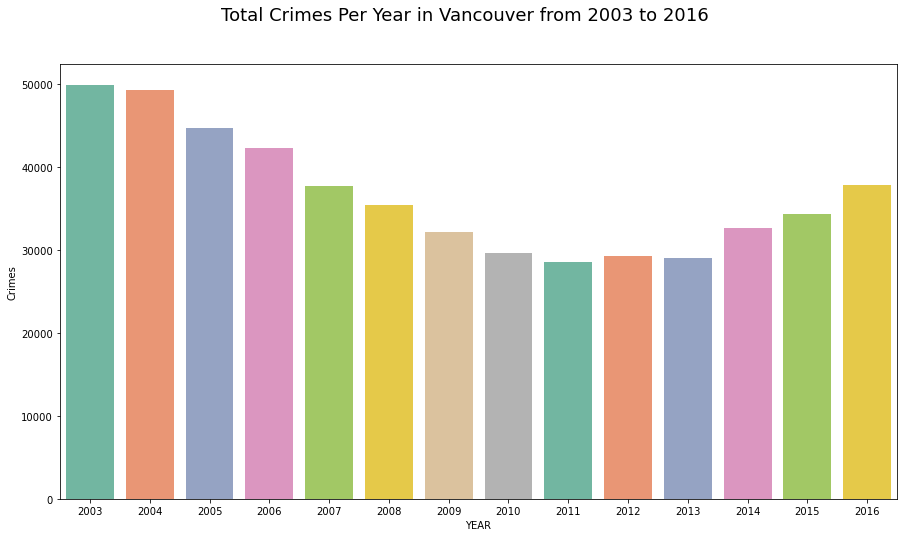

In [11]:
yearly_df = year_df["All"].drop(index = ["All"]).reset_index()
yearly_df.rename(columns = {"All" : "Crimes"}, inplace = True)

fig = plt.figure(figsize = (15, 8))
sns.barplot(
    x = "YEAR",
    y = "Crimes",
    data = yearly_df,
    palette = "Set2"
    )
fig.suptitle(
    "Total Crimes Per Year in Vancouver from 2003 to 2016",
    fontsize = 18
)
plt.show()

*It should be noted that since 2017 doesn't include an entire year's crimes (it stops in July), it has simply been excluded from this section.*

Indeed, it does appear at first as if there is some decrease in crime through the years!

Let's look to see how "linear" the data actually is.

### Pearson Correlation Coefficient

Here we will use our formula for the Sample Correlation Coeffiecent, using our Yearly Count as $x$ and our Year as $y$. The formula is as follows: 

$$ r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{n(\sum x^2) - (\sum x)^2}\sqrt{n(\sum y^2) - (\sum y)^2}} $$

This variable $r$ is a measure of how "linear" the graph is. For data that is completely non-linear, $r$ will be 0, and as the data becomes more linear, $r$ will approach either $1$ or $-1$.

In [12]:
slope, intercept, r, p, error = linregress(
    yearly_df["YEAR"],
    yearly_df["Crimes"]
)
print("r =", r)

r = -0.7351058405054328


We can see that the correlation coefficient $r = -0.735106$, which seems to indicate some sort of linearity. However, that is only true for our sample here - we still need to make some conclusions about the population.

### Hypothesis Testing for Regression

Let the **null hypothesis** be that the year has no affect on the number of crimes, and the **alternative hypothesis** that there is a linear relationship between them.

In other words:
$$ H_0 : \rho = 0 \\ H_A : \rho \ne 0 $$

We can use this $r$ to calculate $p$, using a t distribution with the following critical values:

$$ t_{calc} = r\sqrt{\frac{n -2}{1 - r^2}} $$

Here, $n = 530639$, since we have that many samples.

With that in mind, we can calculate those $t$-values, and lookup a t table to find our level of $p$ for us to compare to.

*Since we are using python, I used a scipy library to do the calculations.*

In [13]:
print("p =", p)

p = 0.002740146309214047


We can see here that $p = 0.002740146309214047$. 

Since we do not have any special circumstances, we can move forward comparing it to our default 95% confidence rate with $\alpha = 0.05$.

Because $$ 0.0027 < 0.0500 $$
We can conclude that $$ p < \alpha $$

And therefore we know that it is very unlikely for us to have found this data given that the null hypothesis was true. Instead, we can safely reject the null hypothesis, and conclude that **there is indeed correllation between the Year and the number of crimes.**

*This could be to any sort of real world factors - infrastructure changes over time, political decisions, cultural value placed on or against policing, moral changes in Vancouver, etc.*

Let's take a look at what that line might look like against our yearly data.

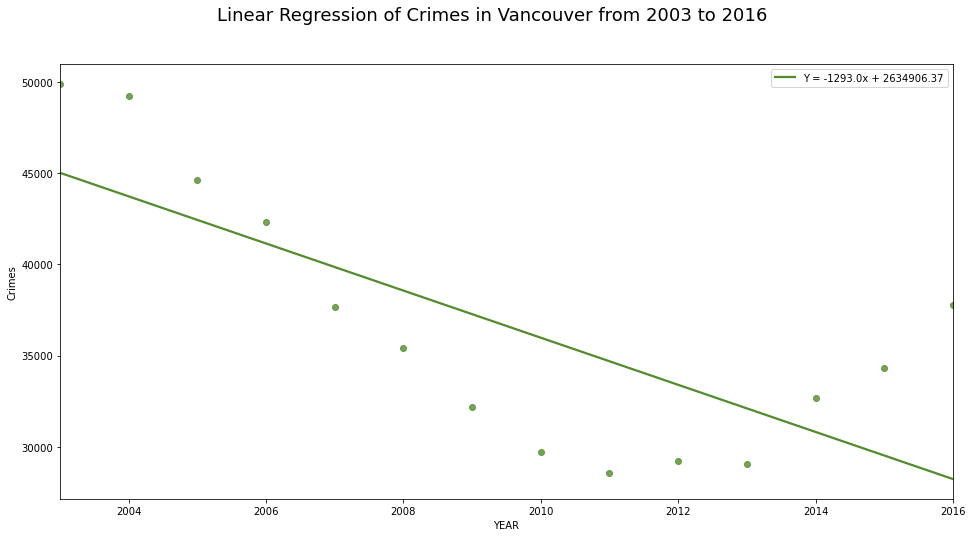

In [14]:
fig, ax = plt.subplots(figsize = (16, 8))
sns.regplot(
    x = "YEAR",
    y = "Crimes",
    data = yearly_df,
    ci = None,
    color = "#558B2F"
    )
ax.legend([f"Y = {round(slope, 2)}x + {round(intercept, 2)}"])
fig.suptitle(
    "Linear Regression of Crimes in Vancouver from 2003 to 2016",
    fontsize = 18
)

plt.show()

Visually, we can plainly see that our line does not catch all the details of the trends in yearly crimes. In this class, we used only a strictly linear test, while the data can be clearly seen to increase after 2013, which our data does not catch. 

While it is true that our Date has correlation with the number of crimes, it would be foolish to not mention that most of the decrease happens from 2004-2011, with the trend significantly changing direction after then.

This can be seen if we calculate the **Coefficient of Determination** with : $$ R^2 = (r)^2 \\ = (-0.7351058405054328)^2 \\ = 0.54038059674 $$

This means that $ 54 \%$ of the variance of the data is NOT accounted for by our linear equation. This is not the ideal model for our sample.

---

# 5 Exploration of Monthly Trends

*Here we will be examining which months, if any, are the worst and best for crime. Then, we hope to answer our research question - did the Olympics affect the crime rate in Vancouver while it was here?*

### Quick Monthly Statistics:

The mean, calculated as follows, is a mathematical representation of the average outcome of a variable.

$$ \bar x = \frac{\sum_{i=1}^n x_i}{n-1}$$

We can use this calculation for each of the months in the year, in order to find the average number of crimes for each month in the year, as calculated from the 2003 - 2016 sample. 

In [15]:
month_mean_df = year_df.drop(index = "All").mean().reset_index().set_index("MONTH")
month_mean_df.rename(columns = {0 : "Mean Monthly Crimes"}, inplace = True)
month_mean_df.drop(index = "All", inplace = True)

month_mean_df

,Mean Monthly Crimes
MONTH,
Jan,3053.500000
Feb,2717.857143
Mar,3022.428571
Apr,2941.142857
May,3133.928571
Jun,3129.928571
Jul,3173.357143
Aug,3281.642857
Sep,3125.000000


Here we can see that the lowest average rate of crime is in February with 2717.9 crimes on average, and the highest is in August with 2381.6 crimes on average, and all of the other months fall in between.

Let's quickly see what that looks like plotted out:

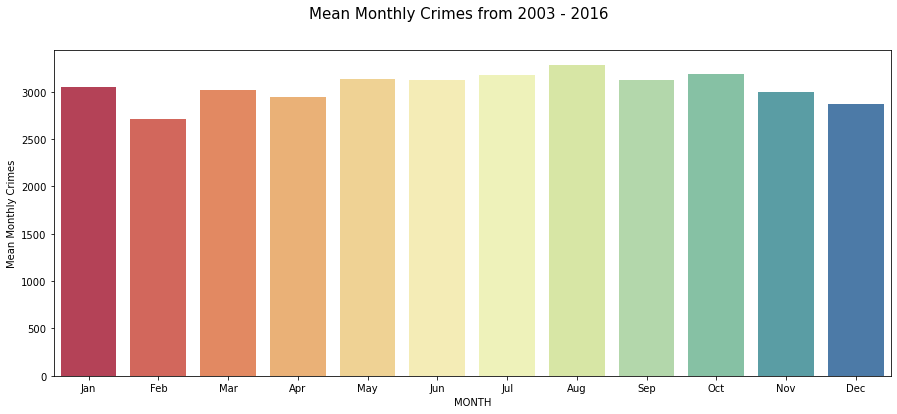

In [16]:
month_mean_df.reset_index(inplace = True)

f, axes = plt.subplots(figsize = (15,6))

sns.barplot(
    x = "MONTH",
    y = "Mean Monthly Crimes",
    data = month_mean_df,
    palette = "Spectral"
)
f.suptitle(
    "Mean Monthly Crimes from 2003 - 2016",
    fontsize = 15
)
plt.show()


We can see that while there ARE some trends, the data is all of fairly similar heights when considering the scale. It doesn't vary that much.

Mathematically, we can come to the same conclusion by using the **Variance** and the **Standard Deviation**.

The Variance, calculated as follows, is a measurement of how much the value of the data set would vary from it's mean. 

$$ S^2 = \frac{\sum_{i=1}^n (x_i - \bar x)^2 }{n - 1}$$

Then, to find the Standard Deviation, we simply find the square root of the variance.

$$ S = \sqrt{S^2} $$

Since we already have the average values for each month, we can easily calculate the variance and standard deviation of each individual month and how much it varies through the years. 

We are going to find out how volitile and prone to change each month is, and use that in tandem with our calculated monthly means to get an idea about the data.

In [17]:
month_std_df = year_df.drop(index = "All").std().reset_index().set_index("MONTH")
month_std_df.rename(columns = {0 : "Standard Deviation of Monthly Crimes"}, inplace = True)
month_std_df.drop(index = "All", inplace = True)
month_std_df


,Standard Deviation of Monthly Crimes
MONTH,
Jan,730.611835
Feb,585.653331
Mar,682.176011
Apr,676.894476
May,702.566664
Jun,613.122709
Jul,547.154402
Aug,598.962257
Sep,614.225216


There are a couple conclusions we might take away from this:
* January and May seem quite average when viewing only their mean, but here we can see they have the most variation of all of the months. Perhaps some single events over the years could have contributed to more outliers for those months?

* August, while having the highest mean crime rate, also has a fairly small Standard Deviation. This needs more testing, but could indicate that it is consistantly a crime-ridden month.

* February, while having the fewest average crimes, also has the one of the smallest standard deviation. This means that according to our dataset, February might be pretty consistantly the safest month of the year. 



### A Final Visualization

This may help visualize a comparison of the different crime counts throughout the years.

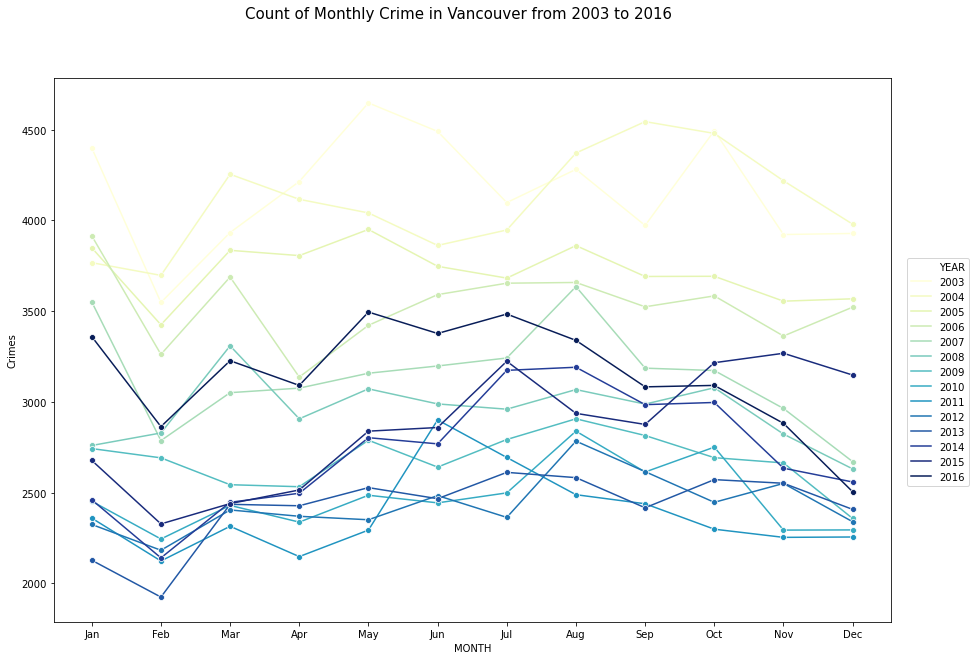

In [65]:
year_vis_df = date_df.groupby(["YEAR", "MONTH"]).count()
year_vis_df.drop(columns = "HUNDRED_BLOCK", inplace = True)
year_vis_df.rename(columns = {"TYPE" : "Crimes"}, inplace = True)
year_vis_df = year_vis_df.drop(index = 2017).reset_index()
year_vis_df = translate_months(year_vis_df)
year_vis_df["YEAR"] = year_vis_df["YEAR"].astype(str)



f, axes = plt.subplots(figsize = (15, 10))
sns.lineplot(
    x = "MONTH",
    y = "Crimes",
    hue = "YEAR",
    data = year_vis_df,
    sort = False,
    legend = "full",
    palette = "YlGnBu",
    marker = "o"
)

plt.legend(
    bbox_to_anchor=(1.02, 0.25),
    loc=3,
    borderaxespad=0.)

f.suptitle(
    "Count of Monthly Crime in Vancouver from 2003 to 2016",
    fontsize = 15
)

plt.show()

Initially I put together this visualization in hopes to compare some trends across the months. Indeed, we can see that there is a small dip in all the Februraries that come up, as well as the Decembers. 

Our small prediction may haved proved true we can see a clear outlier in August 2004 of a strange amount of crimes. Furthermore, we also see the same in May of 2003.

This visualization only serves to cement further our conclusions on yearly trends: Vancouver seems to be improving over the years.

### Olympic Investigation

TODO

1. MAKE FINAL investigations on Olympics with hypothesis testing against the mean.
2. Find a way to include confidence intervals somewehre? Predict the mean of 2017?
3. Clean it up and take away the extra details - or move them to an epilogue.